<a href="https://colab.research.google.com/github/WillyC7/ProgettoDataIntensive/blob/main/Progetto_Carletti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Determinare il prezzo di un automobile usata

**Progetto finale Programmazione di Applicazioni Data Intensive**

Creato da: Carletti William


## Parte 1a - Descrizione del problema

Lo scopo di questo progetto è quello di creare un modello capace di predire il prezzo di vendita di un'automobile usata in base ai dati relativi alle auto attualmente presenti sul mercato.
Il progetto considererà solo le auto usate di uno specifico brand (Mercedes), presenti nel mercato inglese.

###Caricamento dei dati:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

In [2]:
data = pd.read_csv("merc.csv",)
data["price"] = data["price"].astype("float64")
data

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,SLK,2005,5200.0,Automatic,63000,Petrol,325,32.1,1.8
1,S Class,2017,34948.0,Automatic,27000,Hybrid,20,61.4,2.1
2,SL CLASS,2016,49948.0,Automatic,6200,Petrol,555,28.0,5.5
3,G Class,2016,61948.0,Automatic,16000,Petrol,325,30.4,4.0
4,G Class,2016,73948.0,Automatic,4000,Petrol,325,30.1,4.0
...,...,...,...,...,...,...,...,...,...
13114,C Class,2020,35999.0,Automatic,500,Diesel,145,55.4,2.0
13115,B Class,2020,24699.0,Automatic,2500,Diesel,145,55.4,2.0
13116,GLC Class,2019,30999.0,Automatic,11612,Diesel,145,41.5,2.1
13117,CLS Class,2019,37990.0,Automatic,2426,Diesel,145,45.6,2.0


Il numero totale di record si attesta a 13119, con 9 feature.
Di seguito trovamo l'occupazione di memoria del dataset grezzo.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13119 entries, 0 to 13118
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         13119 non-null  object 
 1   year          13119 non-null  int64  
 2   price         13119 non-null  float64
 3   transmission  13119 non-null  object 
 4   mileage       13119 non-null  int64  
 5   fuelType      13119 non-null  object 
 6   tax           13119 non-null  int64  
 7   mpg           13119 non-null  float64
 8   engineSize    13119 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 922.6+ KB


###Significato dei dati:

Le feature del dataset sono le seguenti:


#### Dati categorici
*   model : il modello di auto;
*   transmission: il tipo di trasmissione;
*   fuelType: il carburante utilizzato.

#### Dati numerici
*   year: anno di immatricolazione del mezzo;
*   mileage: le miglia totali percorse;
*   tax: tassa annuale (in sterline);
*   mpg: miglia percorse con un gallone di carburante;
*   engineSize: dimensioni del motore, indicato come i litri di carburante e aria che esso è in grado di iniettare nei cilindri;
*   price: prezzo (in sterline) a cui viene proposta l'automobile.

Quest'ultima rappresenta anche la variabile di cui vogliamo predire il valore. Essa è continua, dunque ci troviamo davanti ad un problema di regressione.



Per ottimizzare l'occupazione in memoria, benchè il numero di righe non sia molto elevato, si convertono le feature model, transmission e fuelType da tipo object a category.

In [4]:
categoric_features = ["model","transmission","fuelType"];
numeric_features = ["year","price","mileage","tax","mpg","engineSize"];

In [5]:
for feature in categoric_features:
    data[feature] = data[feature].astype("category")

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13119 entries, 0 to 13118
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   model         13119 non-null  category
 1   year          13119 non-null  int64   
 2   price         13119 non-null  float64 
 3   transmission  13119 non-null  category
 4   mileage       13119 non-null  int64   
 5   fuelType      13119 non-null  category
 6   tax           13119 non-null  int64   
 7   mpg           13119 non-null  float64 
 8   engineSize    13119 non-null  float64 
dtypes: category(3), float64(3), int64(3)
memory usage: 655.3 KB


###Pulizia dati
Per prima cosa, andiamo a controllare l'eventuale presenza di record nulli.

In [7]:
data.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

Come possiamo notare, nessuna feature presenta valori nulli.

In seguito, andiamo ad ricavare da year la feature **age**, ossia l'età della macchina. Questa feature risulta essere più accurata dell'anno di immatricolazione, in quanto è indipendente dall'anno in cui ci troviamo, perciò sostituirà year. Tale operazione viene fatta considerando l'anno in cui sono stati rilevati i dati, ossia il 2020. 

In [8]:
data["age"] = 2020 - data["year"];
data.drop(columns="year",inplace=True);
numeric_features.append("age");
numeric_features.remove("year");

##Parte 1b - Analisi esplorativa

Per prima cosa andiamo ad osservare le caratteristiche di base delle sole feature numeriche appartenenti ai dati analizzati.

In [10]:
data.describe()

,price,mileage,tax,mpg,engineSize,age
count,13119.000000,13119.000000,13119.000000,13119.000000,13119.000000,13119.000000
mean,24698.596920,21949.559037,129.972178,55.155843,2.071530,2.703712
std,11842.675542,21176.512267,65.260286,15.220082,0.572426,2.224709
min,650.000000,1.000000,0.000000,1.100000,0.000000,0.000000
25%,17450.000000,6097.500000,125.000000,45.600000,1.800000,1.000000
50%,22480.000000,15189.000000,145.000000,56.500000,2.000000,2.000000
75%,28980.000000,31779.500000,145.000000,64.200000,2.100000,4.000000
max,159999.000000,259000.000000,580.000000,217.300000,6.200000,50.000000


* Come possiamo vedere, le auto analizzate in media hanno sui **3 anni di vita**, e solo il 25% di esse risalgono ad un anno precedente al **2016**.
* Il prezzo medio si aggira sulle **24000 sterline**, appropriato se si considera la fama del marchio automobilistico. La deviazione standard si attesta sulle **12000 sterline**, valore dovuto sia alla varietà di tipologie di veicoli che alle condizioni in cui essi si trovano.
* Osservando i dati relativi alle miglia percorsa dai veicoli, invece, ci accorgiamo che il 75% di essi non supera le **32000 miglia** (~52000 chilometri), dato sicuramente influenzato dall'età media delle auto.
* Passando al costo della tassa di registrazione del mezzo, notiamo che il prezzo medio si attesta sulle **130 £**, ma la deviazione standard del dato risulta essere anch'essa abbastanza elevata: controllando la tassazione effettuata nel Regno Unito, scopriamo che il prezzo deriva dalle emissioni di CO2 prodotte dal veicolo. Ciò ci fa presagire al fatto che il dataset contenga auto con efficienza differente: abbiamo infatti sia vetture ibride che vetture dotate di motore da 6.2L.
* Infine, la potenza media del motore si attesta sui **2L**, potenza comune in questa fascia di mercato.

Per vedere meglio questi dati, ci affidiamo alle rappresentazioni boxplot.

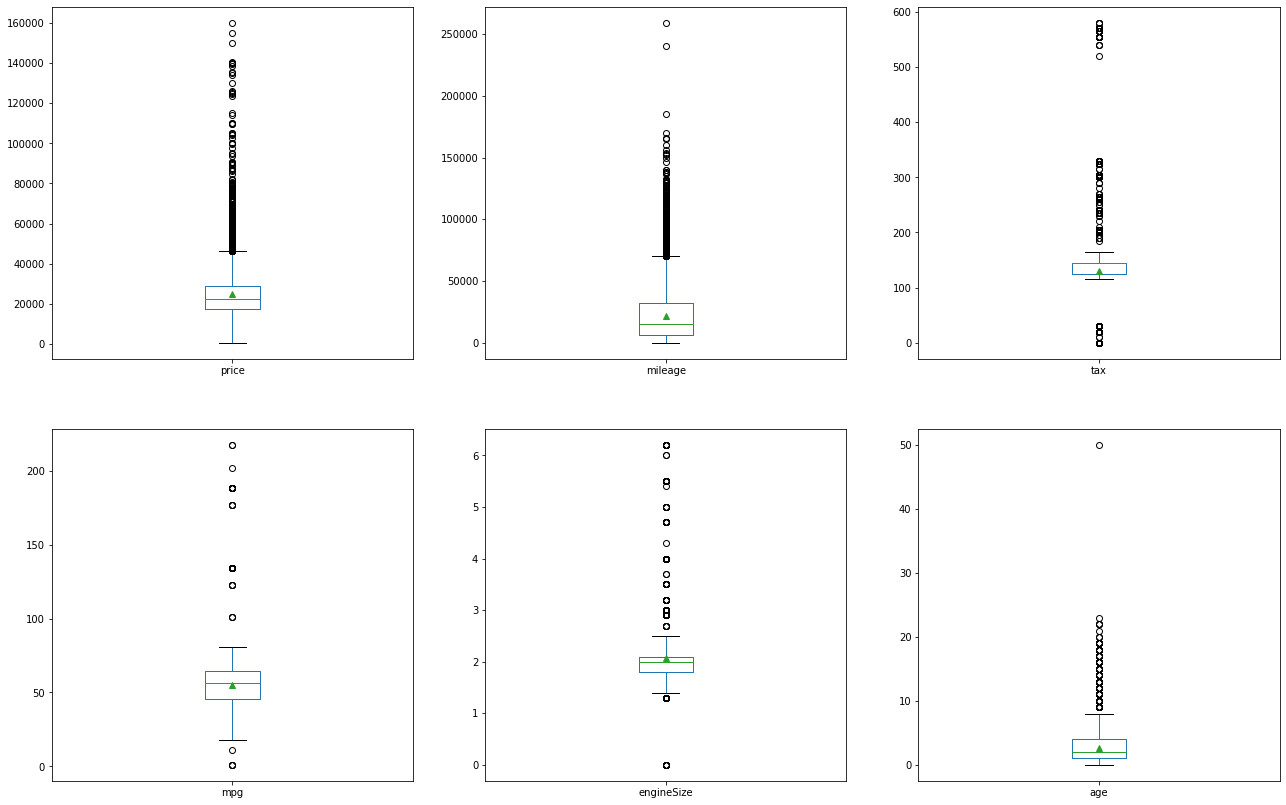

In [11]:
plt.figure(figsize=(22, 22))
for n, col in enumerate(numeric_features, start=1):
    data[col].plot.box(showmeans=True,ax=plt.subplot(3, 3, n))

Come possiamo notare, tutte le feature contengono diversi outliers. In alcune, questi valori sono ben distribuiti, mentre in altre, ossia age e mileage, sono presenti pochi outliers notevolmente distanti da tutti gli altri valori. Si procede perciò alla rimozione delle seguenti righe:

In [12]:
data = data.loc[(data.age < 40) & (data.mileage < 200000),:]

Verifichiamo di nuovo il box-plot delle sopracitate feature, così da mostrare la differenza di omogeneità degli outliers.

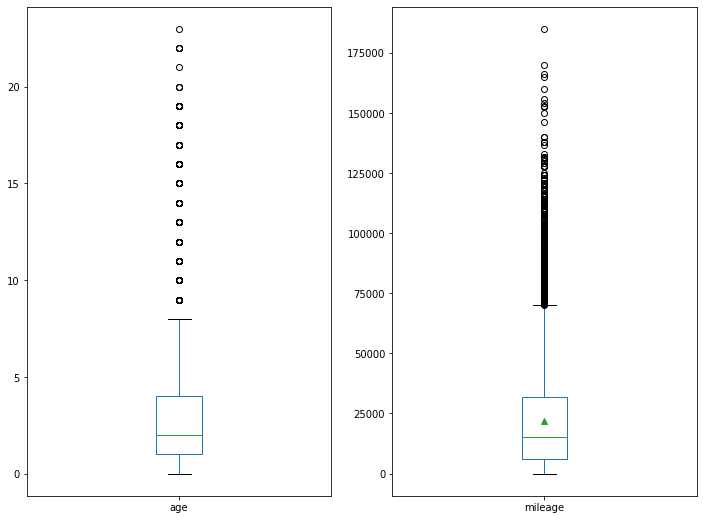

In [14]:
plt.figure(figsize=(12, 9))
data.age.plot.box(ax=plt.subplot(1, 2, 1))
data.mileage.plot.box(showmeans=True,ax=plt.subplot(1, 2, 2))


Passando alle feature categoriche, possiamo osservarne il numero di valori distinti per ciascuna di esse.

In [15]:
for feature in categoric_features:
  print("Count of unique values of feature " + feature + " : {}".format(data.loc[:,feature].nunique()))

Count of unique values of feature model : 27
Count of unique values of feature transmission : 4
Count of unique values of feature fuelType : 4


Notiamo dunque che sia la trasmissione che il tipo di carburante utilizzato dai mezzi analizzati hanno scarsa variabilità.

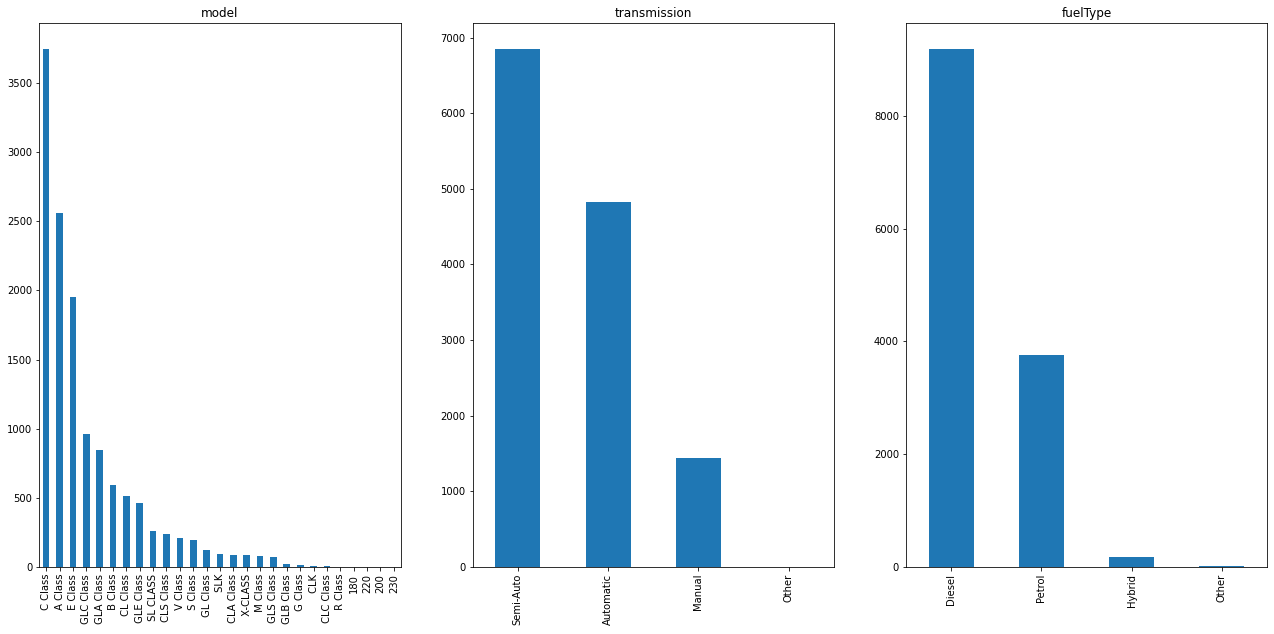

In [16]:
plt.figure(figsize=(22, 10))
for n, col in enumerate(categoric_features, start=1):
    data[col].value_counts().plot.bar(ax=plt.subplot(1, 3, n))
    plt.title(col)

Da questi grafici notiamo il modello più presente sul mercato, ossia il Classe C. Possiamo inoltre osservare che sono presenti alcuni veicoli con una trasmissione e tipo di carburante definiti come *Other*.
Per quanto riguarda la prima feature, i record potrebbero riferirsi ad una trasmissione Continuously Variable Transmission (CVT), ossia una trasmissione per certi versi simile ad una automatica, usata in specifici modelli di automobile.

In [18]:
otherCars = data.loc[data.transmission == "Other"];
display(otherCars);
print("\nNumero di veicoli con trasmissione 'other': {}".format(len(otherCars)));

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,age
9650,GLA Class,18700.0,Other,30895,Other,125,56.5,0.0,4
12762,SLK,12995.0,Other,39000,Diesel,150,56.5,2.1,5


Numero di veicoli: 2


Facendo una ricerca si scopre che nessuno dei due modelli riportati è mai stato equipaggiato con tale trasmissione; si decide quindi di rimuovere i due record.

Passando al tipo di carburante, il valore other potrebbe riferirsi ad automobili elettriche, sempre più popolari, oppure a modelli alimentati ad idrogeno, molto meno popolari nel mercato odierno.

In [19]:
otherCars = data.loc[data.fuelType == "Other"];
display(otherCars);
print("\nNumero di veicoli con tipo di carburante 'other': {}".format(len(otherCars)));

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,age
9650,GLA Class,18700.0,Other,30895,Other,125,56.5,0.0,4
11740,GLE Class,31990.0,Automatic,46000,Other,0,76.4,3.0,4
12095,C Class,13850.0,Automatic,77814,Other,0,134.5,2.0,4
12184,C Class,17400.0,Automatic,52897,Other,0,134.5,2.0,3
12270,C Class,16000.0,Automatic,54011,Other,0,134.5,2.0,3
12389,C Class,15000.0,Automatic,53400,Other,0,134.5,2.0,5
12894,C Class,40999.0,Automatic,400,Other,135,217.3,2.0,0



Numero di veicoli con tipo di carburante 'other': 7


Anche in questo caso, le auto ottenute non sono modelli elettrici o ad idrogeno, quindi andiamo ad eliminare anche questi 7 record, mostrando di nuovo i grafici a barre dopo la rimozione.

In [20]:
data = data.loc[(data.transmission != "Other") & (data.fuelType != "Other"),:]
data.transmission.cat.remove_categories(removals=["Other"],inplace=True)
data.fuelType.cat.remove_categories(removals=["Other"],inplace=True)

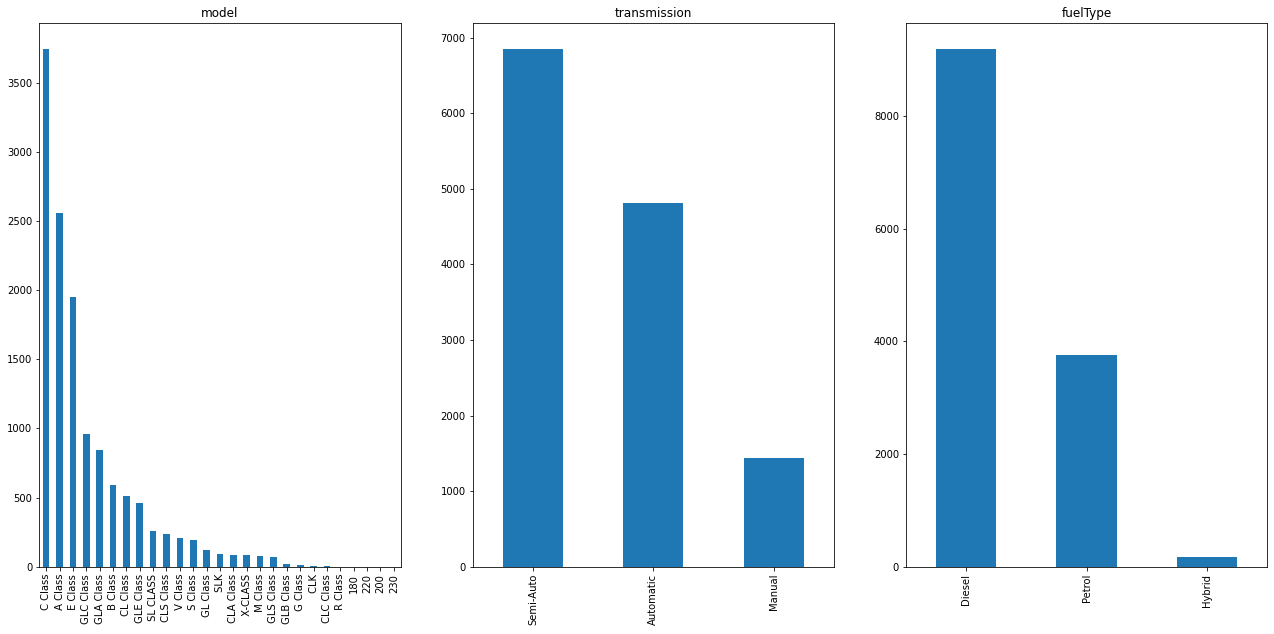

In [21]:
plt.figure(figsize=(22, 10))
for n, col in enumerate(categoric_features, start=1):
    data[col].value_counts().plot.bar(ax=plt.subplot(1, 3, n))
    plt.title(col)

###Correlazione tra coppie di feature

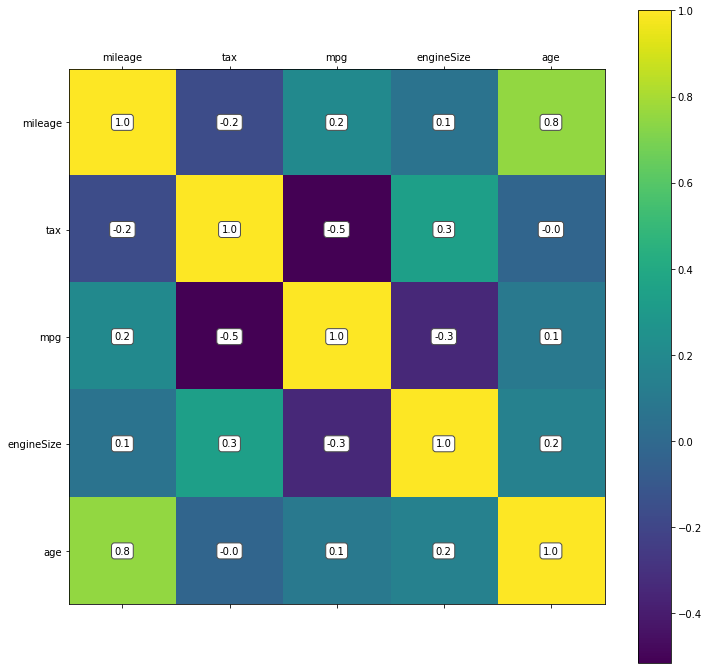

In [22]:
corr = data.drop(columns=["price"]).corr()

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.matshow(corr,cmap="viridis")
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);
fig.colorbar(im);
for (i, j), z in np.ndenumerate(corr):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.show();

Questo grafico mostra **l'indice di correlazione di Pearson** (quindi compreso tra -1 e 1) tra le coppie di feature numeriche.

* Tra prezzo della tassa e miglia per gallone troviamo una correlazione negativa: questo è dovuto probabilmente al fatto che un'auto poco efficiente nell'uso di carburante produrrà anche più anidride carbonica, facendo aumentare così la sopracitata tassa.
* Altra correlazione è quella che intercorre tra miglia percorse ed età del mezzo; risulta infatti ovvio che, normalmente, più un auto è recente e meno miglia avrà percorso.
* Possiamo notare infine una lieve correlazione tra dimensione del motore e miglia per gallone, indicando che un motore più potente porti solitamente a consumi più elevati ed una efficienza ridotta.

##Parte 2 - Data Preprocessing

Per prima cosa, andiamo ad estrarre la variabile dipendente da predire dal resto dei dati. Il prezzo da calcolare, inoltre, viene convertito in migliaia di sterline, così da mantenere i coefficienti di regressione più bassi.

In [23]:
y = data["price"];
X = data.drop(columns=["price"]);
numeric_features.remove("price")

###Hold Out
Viene in seguito diviso il dataset in training e validation set, con una divisione di 2/3 ed 1/3 rispettivamente.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=1/3,random_state=43);

y_scaler = StandardScaler();

y_scaler.fit(y.values[:,None])

y_train_unscaled = y_train
y_val_unscaled = y_val

y_train = y_scaler.transform(y_train.values[:,None]).ravel()
y_val = y_scaler.transform(y_val.values[:,None]).ravel()

###Utilizzo feature categoriche
Per poter utilizzare le variabili categoriche nei modelli che vogliamo costruire, verrà utilizzata la tecnica chiamata **One Hot Encoding**.
Questo meccanismo trasforma tali feature in feature numeriche, così da poterle utilizzare nella creazione dei modelli di regressione.
Per poter selezionare le sole colonne categoriche ed applicare l'encoding, viene inoltre utilizzato un **ColumnTransformer**; esso ci permetterà in seguito di standardizzare le sole feature numeriche.

###Standardizzazione
Per quanto riguarda la standardizzazione delle feature numeriche, considerando la differenza delle scale di valore di esse, possiamo ipotizzare che il suo utilizzo migliori i risultati notevolmente. Per dimostrare ciò, verranno creati due modelli di regressione lineare semplice, utlizzando solo nel primo caso uno StandardScaler; questi modelli verranno confrontati mediante l'utilizzo delle tre tecniche principali di valutazione di modelli di regressione.

In [27]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import t


gsParams = ["rank_test_score","mean_test_score","params"]

def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true));

def print_eval(X, y, model):
    actual_printing(y,model.predict(X))

def print_eval_scaled(X, y, model):
    preds = model.predict(X)
    unscaled_preds = y_scaler.inverse_transform(preds);
    unscaled_y = y_scaler.inverse_transform(y);
    actual_printing(unscaled_y,unscaled_preds)

def actual_printing(y,preds):
    print("   Mean squared error: {:.5}".format(mean_squared_error(y, preds)))
    print("       Relative error: {:.5%}".format(relative_error(y, preds)))
    print("R-squared coefficient: {:.5}".format(r2_score(y, preds)))

def print_param_eval(gridSearch):
    print("\nDettagli parametri GridSearch:")
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', 100):  
      display(pd.DataFrame(gridSearch.cv_results_).sort_values("mean_test_score", ascending=False).head(5)[gsParams])

def print_accuracy_with_confidence(X,y,model,confidence):
    preds = model.predict(X)
    unscaled_preds = y_scaler.inverse_transform(preds);
    unscaled_y = y_scaler.inverse_transform(y);
    instanceNum = len(X.index);
    r2 = r2_score(unscaled_y,unscaled_preds);
    Z = t.ppf(1 - ((1-confidence) / 2), instanceNum);
    stdDev = np.sqrt((4*r2*np.square(1-r2)*np.square(instanceNum - 1))/((np.square(instanceNum) - 1)*(instanceNum + 3)))
    print("\nAccuratezza con il {}% di confidenza:".format(confidence*100))
    print("R^2 min: {}".format(r2 - (Z*stdDev)))
    print("R^2 max: {}".format(r2 + (Z*stdDev)))

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

In [29]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categorical", OneHotEncoder(handle_unknown='ignore'), categoric_features)
    ])),
    ("linreg" , LinearRegression())
])
model.fit(X_train,y_train)
print_eval_scaled(X_val,y_val,model)

   Mean squared error: 3.4283e+07
       Relative error: 16.67914%
R-squared coefficient: 0.74982


In [30]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("categorical", OneHotEncoder(handle_unknown='ignore'), categoric_features)
    ])),
    ("linreg" , LinearRegression())
])
model.fit(X_train,y_train_unscaled)
print_eval(X_val,y_val_unscaled,model)

   Mean squared error: 8.5196e+07
       Relative error: 29.42306%
R-squared coefficient: 0.37827


Come possiamo notare, benchè sia stato utilizzato solo un modello lineare, il guadagno in termini di accuratezza risulta essere considerevole.

###Individuazione feature più rilevanti

Per rilevare le feature più rilevanti nel problema analizzato, verrà creato un modello di regressione mediante Lasso, che utilizza una regolarizzazione di tipo L1.

In [31]:
scaled_y = y_scaler.fit_transform(y.values[:, None]).ravel();
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categoric", OneHotEncoder(handle_unknown='ignore'), categoric_features)
    ])),
    ("reg" , Lasso(alpha=0.01))
])
model.fit(X_train,y_train)
coefs = model.named_steps["reg"].coef_;
enc_categ_features = model.named_steps["preproc"].named_transformers_['categoric'].get_feature_names()
labels = np.concatenate([numeric_features, enc_categ_features]);
print(pd.Series(data=coefs,index=labels))
print_eval_scaled(X_val,y_val,model)

mileage         -0.214636
tax             -0.055801
mpg             -0.170123
engineSize       0.524046
age             -0.402664
x0_ A Class     -0.000000
x0_ B Class     -0.004541
x0_ C Class     -0.030071
x0_ CL Class    -0.000000
x0_ CLA Class   -0.000000
x0_ CLC Class    0.000000
x0_ CLK          0.000000
x0_ CLS Class   -0.000000
x0_ E Class     -0.000000
x0_ G Class      0.000000
x0_ GL Class    -0.000000
x0_ GLA Class   -0.079161
x0_ GLB Class    0.000000
x0_ GLC Class    0.143802
x0_ GLE Class    0.158881
x0_ GLS Class    0.000000
x0_ M Class      0.000000
x0_ R Class     -0.000000
x0_ S Class      0.132043
x0_ SL CLASS    -0.000000
x0_ SLK          0.000000
x0_ V Class      0.000000
x0_ X-CLASS     -0.000000
x0_200          -0.000000
x0_220          -0.000000
x0_230           0.000000
x1_Automatic     0.000000
x1_Manual       -0.079643
x1_Semi-Auto     0.000000
x2_Diesel       -0.093278
x2_Hybrid        0.000000
x2_Petrol        0.000000
dtype: float64
   Mean squared error: 

Osservando i coefficienti di regressione associati alle relative variabili di input, possiamo vedere che diversi di loro sono stati annullati, non perdendo nulla in accuratezza. Notiamo inoltre che per la feature transmission solo un coefficiente è non nullo: questo ci fa capire che il cambio dell'automobile non incida particolarmente sul suo prezzo.

In [32]:
print(pd.Series(data=coefs,index=labels).abs().sort_values(ascending=False).head(5))

engineSize       0.524046
age              0.402664
mileage          0.214636
mpg              0.170123
x0_ GLE Class    0.158881
dtype: float64


Settando l'iperparametro alpha a 0.1, il modello ci indica l'importanza che la **motorizzazione**, l'**età** del mezzo e le **miglia percorse** in totale, hanno nel calcolo del prezzo di un'auto usata. In seguito, troviamo le **miglia percorribili per gallone** ed il **modello** dell'automobile. Verrà verificato nella parte 5 se il modello migliore consideri tali feature fondamentali per il calcolo del prezzo.

##Parte 3 - Modellazione

Vengono in seguito creati diversi modelli di regressione.
Per ogni modello vengono mostrate:
* le tre principali metriche di valutazione (ossia MSE, errore relativo e coefficiente r^2);
* le medie degli score sulle istanze di training con degli specifici parametri;
* il valore del coefficiente r^2 con confidenza del 95%.

In [33]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

kf = KFold(n_splits=4,shuffle=True,random_state=42)

###Regressione Polinomiale

Partiamo con la creazone di un modello di regressione polinomiale senza regolarizzazione, facendo una grid search per il grado migliore a cui elevare i dati.

In [34]:
numeric_preproc = Pipeline([
    ("std",StandardScaler()),
    ("poly",PolynomialFeatures(include_bias=False))
]);

model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", numeric_preproc, numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , LinearRegression())
])
grid = {
    "preproc__numeric__poly__degree": [2, 3, 4]
}
gsPol = GridSearchCV(model, grid, cv=kf)
gsPol.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gsPol)
print_param_eval(gsPol)
print_accuracy_with_confidence(X_val,y_val,gsPol,0.95)

   Mean squared error: 2.218e+07
       Relative error: 11.69574%
R-squared coefficient: 0.83814

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
0,1,0.848578,{'preproc__numeric__poly__degree': 2}
2,2,0.847114,{'preproc__numeric__poly__degree': 4}
1,3,0.845186,{'preproc__numeric__poly__degree': 3}



Accuratezza con il 95.0% di confidenza:
R^2 min: 0.8293526364240574
R^2 max: 0.8469215201372758


###Regressione Ridge

Proviamo ad applicare un modello di regressione lineare con regolarizzazione. Nella grid search verrà variato l'iperparametro *alpha*, ossia l'intensità della regolarizzazione

In [35]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , Ridge())
])
grid = {
    "reg__alpha":[0.01,0.1,1,10]
}
gsRid1 = GridSearchCV(model, grid, cv=kf, refit=True)
gsRid1.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gsRid1)
print_param_eval(gsRid1)

print_accuracy_with_confidence(X_val,y_val,gsRid1,0.95)

   Mean squared error: 3.3825e+07
       Relative error: 16.64138%
R-squared coefficient: 0.75316

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
2,1,0.779509,{'reg__alpha': 1}
1,2,0.777929,{'reg__alpha': 0.1}
0,3,0.777599,{'reg__alpha': 0.01}
3,4,0.771553,{'reg__alpha': 10}



Accuratezza con il 95.0% di confidenza:
R^2 min: 0.7404574538211867
R^2 max: 0.765855685108307


In questo caso notiamo che, tranne con alpha molto grande (e quindi con molta regolarizzazione), lo score rimanga più o meno lo stesso.

###Regressione Ridge Polinomiale
Testiamo di nuovo la regressione ridge, ma in questo caso aumentiamo la dimensionalità. La Grid Search, quindi constaterà il grado migliore a cui elevare le feature numeriche per ottenere un miglior score.

In [36]:
numeric_preproc = Pipeline([
    ("std",StandardScaler()),
    ("poly",PolynomialFeatures(include_bias=False))
]);

model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", numeric_preproc, numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , Ridge())
])
grid = {
    "preproc__numeric__poly__degree": [2, 3, 4],
    "reg__alpha":[0.01,0.1,1,10]
}
gsRid2 = GridSearchCV(model, grid, cv=kf, refit=True)
gsRid2.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gsRid2)
print_param_eval(gsRid2)
print_accuracy_with_confidence(X_val,y_val,gsRid2,0.95)

   Mean squared error: 2.1743e+07
       Relative error: 11.56841%
R-squared coefficient: 0.84133

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
2,1,0.850740,"{'preproc__numeric__poly__degree': 2, 'reg__alpha': 1}"
1,2,0.848950,"{'preproc__numeric__poly__degree': 2, 'reg__alpha': 0.1}"
0,3,0.848617,"{'preproc__numeric__poly__degree': 2, 'reg__alpha': 0.01}"
8,4,0.847789,"{'preproc__numeric__poly__degree': 4, 'reg__alpha': 0.01}"
9,5,0.847783,"{'preproc__numeric__poly__degree': 4, 'reg__alpha': 0.1}"



Accuratezza con il 95.0% di confidenza:
R^2 min: 0.8326988305362005
R^2 max: 0.8499542625268633


Rispetto al modello lineare, notiamo subito un grande miglioramento per quanto riguarda lo score, che ora si aggira sul 0.84. Nonostante ciò, tale score risulta essere simile a quello ottenuto senza regolarizzazione.

###Regressione Ridge Polinomiale (includendo feature categoriche polinomiali)

In questo caso, invece di elevare la dimensionalità delle sole feature numeriche, generiamo le feature polinomiali di tutte le colonne ottenute in seguito al preprocessing. Per evitare di avere le feature polinomiali delle variabili categoriche encoded, le quali sarebbero ridondanti, si imposterà il parametro **interaction_only a True**, così da utilizzare solo le combinazioni tra le variabili prodotte dal preprocessore.

In [ ]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("poly", PolynomialFeatures(include_bias=False,interaction_only=True)),
    ("reg" , Ridge())
])
grid = {
    "reg__alpha":[0.01,0.1,1,10]
}
gsRid3 = GridSearchCV(model, grid, cv=kf, refit=True)
gsRid3.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gsRid3)
print_param_eval(gsRid3)
print_accuracy_with_confidence(X_val,y_val,gsRid3,0.95)

   Mean squared error: 1.6385e+07
       Relative error: 10.19223%
R-squared coefficient: 0.88043

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
3,1,0.900943,{'reg__alpha': 10}
2,2,0.899753,{'reg__alpha': 1}
1,3,0.898768,{'reg__alpha': 0.1}
0,4,0.898092,{'reg__alpha': 0.01}



Accuratezza con il 95.0% di confidenza:
R^2 min: 0.8737801918573658
R^2 max: 0.8870818404769072


Notiamo un ulteriore miglioramento rispetto al modello precedente; in questo caso viene preferita una regolarizzazione più elevata.

###Regressione Lasso

Creiamo ora dei modelli che utilizzano la regolarizzazione L1 mediante Lasso.

In [37]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , Lasso())
])
grid = {
    "reg__alpha":[0.01,0.1,1,10]
}
gsLas1 = GridSearchCV(model, grid, cv=kf, refit=True)
gsLas1.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gsLas1)
print_param_eval(gsLas1)
print_accuracy_with_confidence(X_val,y_val,gsLas1,0.95)

   Mean squared error: 4.0546e+07
       Relative error: 17.82186%
R-squared coefficient: 0.70411

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
0,1,0.721737,{'reg__alpha': 0.01}
1,2,0.678031,{'reg__alpha': 0.1}
2,3,-0.000803,{'reg__alpha': 1}
3,3,-0.000803,{'reg__alpha': 10}



Accuratezza con il 95.0% di confidenza:
R^2 min: 0.6893947553732059
R^2 max: 0.7188312654541674


Otteniamo in questo caso uno score più basso del modello Ridge lineare.

###Regressione Lasso polinomiale
Testiamo ora la regressione Lasso utilizzando anche le feature polinomiali generate partendo dalle sole variabili numeriche.

In [38]:
numeric_preproc = Pipeline([
    ("std",StandardScaler()),
    ("poly",PolynomialFeatures(include_bias=False))
]);

model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", numeric_preproc, numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , Lasso())
])
grid = {
    "preproc__numeric__poly__degree": [2, 3, 4],
    "reg__alpha":[0.01,0.1,1,10],
}
gsLas2 = GridSearchCV(model, grid, cv=kf, refit=True)
gsLas2.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gsLas2)
print_param_eval(gsLas2)
print_accuracy_with_confidence(X_val,y_val,gsLas2,0.95)

   Mean squared error: 2.574e+07
       Relative error: 12.67452%
R-squared coefficient: 0.81216

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
8,1,0.821883,"{'preproc__numeric__poly__degree': 4, 'reg__alpha': 0.01}"
4,2,0.819057,"{'preproc__numeric__poly__degree': 3, 'reg__alpha': 0.01}"
0,3,0.805295,"{'preproc__numeric__poly__degree': 2, 'reg__alpha': 0.01}"
5,4,0.734444,"{'preproc__numeric__poly__degree': 3, 'reg__alpha': 0.1}"
1,5,0.733101,"{'preproc__numeric__poly__degree': 2, 'reg__alpha': 0.1}"



Accuratezza con il 95.0% di confidenza:
R^2 min: 0.8021271017971013
R^2 max: 0.8221969461845223


Come nel caso della regressione Ridge, anche in questo caso l'utilizzo delle feature polinomiali porta ad un sensibile miglioramento dello score rispetto al caso lineare.

###Regressione Lasso Polinomiale (includendo feature categoriche polinomiali)

Ripetiamo, come con Ridge, la creazione di un modello con feature polinomiali, considerando solo i termini che rappresentano combinazioni di variabili.

In [39]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("poly",PolynomialFeatures(include_bias=False,interaction_only=True)),
    ("reg" , Lasso())
])
grid = {
    "reg__alpha":[0.01,0.1,1,10],
}
gsLas3 = GridSearchCV(model, grid, cv=kf, refit=True)
gsLas3.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gsLas3)
print_param_eval(gsLas3)
print_accuracy_with_confidence(X_val,y_val,gsLas3,0.95)

   Mean squared error: 2.2193e+07
       Relative error: 12.61243%
R-squared coefficient: 0.83804

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
0,1,0.834782,{'reg__alpha': 0.01}
1,2,0.711374,{'reg__alpha': 0.1}
2,3,-0.000803,{'reg__alpha': 1}
3,3,-0.000803,{'reg__alpha': 10}



Accuratezza con il 95.0% di confidenza:
R^2 min: 0.8292523290647885
R^2 max: 0.8468305886761341


A dispetto della Ridge Regression, l'inclusione delle feature categoriche polinomiali non ha migliorato di molto lo score r^2.

###Elastic Net

Ora creiamo un modello che utilizza entrambe le regolarizzazioni, partendo dal caso di feature lineari, passando poi per quello con feature polinomiali numeriche e infine quello con tutte le feature polinomiali.
In questo caso, si cercherà anche il valore migliore dell'iperparametro l1_ratio, ossia l'importanza della regolarizzazione L1 rispetto a quella L2.

In [40]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , ElasticNet())
])
grid = {
    "reg__alpha":[0.01,0.1,1,10],
    "reg__l1_ratio": [0.1, 0.2, 0.3]
}
gsEla1 = GridSearchCV(model, grid, cv=kf, refit=True)
gsEla1.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gsEla1)
print_param_eval(gsEla1)
print_accuracy_with_confidence(X_val,y_val,gsEla1,0.95)

   Mean squared error: 3.6454e+07
       Relative error: 17.03506%
R-squared coefficient: 0.73397

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
0,1,0.752276,"{'reg__alpha': 0.01, 'reg__l1_ratio': 0.1}"
1,2,0.748884,"{'reg__alpha': 0.01, 'reg__l1_ratio': 0.2}"
2,3,0.745056,"{'reg__alpha': 0.01, 'reg__l1_ratio': 0.3}"
3,4,0.708183,"{'reg__alpha': 0.1, 'reg__l1_ratio': 0.1}"
4,5,0.697787,"{'reg__alpha': 0.1, 'reg__l1_ratio': 0.2}"



Accuratezza con il 95.0% di confidenza:
R^2 min: 0.7204622487740453
R^2 max: 0.747483484328842


###Elastic Net polinomiale

In [41]:
numeric_preproc = Pipeline([
    ("std",StandardScaler()),
    ("poly",PolynomialFeatures(include_bias=False))
]);

model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", numeric_preproc, numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , ElasticNet())
])
grid = {
    "preproc__numeric__poly__degree": [2, 3, 4],
    "reg__alpha":[0.01,0.1,1,10],
    "reg__l1_ratio": [0.1, 0.2, 0.3]
}
gsEla2 = GridSearchCV(model, grid, cv=kf, refit=True)
gsEla2.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gsEla2)
print_param_eval(gsEla2)
print_accuracy_with_confidence(X_val,y_val,gsEla2,0.95)

   Mean squared error: 2.3476e+07
       Relative error: 11.70967%
R-squared coefficient: 0.82868

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
24,1,0.840802,"{'preproc__numeric__poly__degree': 4, 'reg__alpha': 0.01, 'reg__l1_ratio': 0.1}"
25,2,0.840510,"{'preproc__numeric__poly__degree': 4, 'reg__alpha': 0.01, 'reg__l1_ratio': 0.2}"
26,3,0.839277,"{'preproc__numeric__poly__degree': 4, 'reg__alpha': 0.01, 'reg__l1_ratio': 0.3}"
13,4,0.831790,"{'preproc__numeric__poly__degree': 3, 'reg__alpha': 0.01, 'reg__l1_ratio': 0.2}"
12,5,0.831658,"{'preproc__numeric__poly__degree': 3, 'reg__alpha': 0.01, 'reg__l1_ratio': 0.1}"



Accuratezza con il 95.0% di confidenza:
R^2 min: 0.8194374139703243
R^2 max: 0.8379273474665955


Lo score si avvicina, ma non supera, quello ottenuto dal modello con la sola regolarizzazione L2.

###Elastic Net polinomiale (includendo feature categoriche polinomiali)

In [42]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("poly",PolynomialFeatures(include_bias=False,interaction_only=True)),
    ("reg" , ElasticNet())
])
grid = {
    "reg__alpha":[0.01,0.1,1,10],
    "reg__l1_ratio": [0.1, 0.2, 0.3]
}

gsEla3 = GridSearchCV(model, grid, cv=kf, refit=True)
gsEla3.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gsEla3)
print_param_eval(gsEla3)
print_accuracy_with_confidence(X_val,y_val,gsEla3,0.95)

   Mean squared error: 1.654e+07
       Relative error: 10.71328%
R-squared coefficient: 0.8793

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
0,1,0.884829,"{'reg__alpha': 0.01, 'reg__l1_ratio': 0.1}"
1,2,0.877508,"{'reg__alpha': 0.01, 'reg__l1_ratio': 0.2}"
2,3,0.871308,"{'reg__alpha': 0.01, 'reg__l1_ratio': 0.3}"
3,4,0.808137,"{'reg__alpha': 0.1, 'reg__l1_ratio': 0.1}"
4,5,0.790020,"{'reg__alpha': 0.1, 'reg__l1_ratio': 0.2}"



Accuratezza con il 95.0% di confidenza:
R^2 min: 0.8725906302395383
R^2 max: 0.8860094681747517


Come per il modello precedente, lo score è leggermente più basso a quello del modello Ridge.

###Kernel Ridge

In questa modellazione verranno valutate due funzioni kernel:

*   Kernel Polinomiale
*   Radial Basis Function

In base alla funzione kernel verranno verificati gli iperparametri alpha (poly) e gamma (rbf).


In [46]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , KernelRidge(kernel="poly"))
])
grid = [
    {
      "reg__degree":[2,3,4],
      "reg__alpha":[0.01,0.1,1,10]
    }
]

gsKerPoly = GridSearchCV(model, grid, cv=kf, refit=True)
gsKerPoly.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gsKerPoly)
print_param_eval(gsKerPoly)
print_accuracy_with_confidence(X_val,y_val,gsKerPoly,0.95)

   Mean squared error: 1.289e+07
       Relative error: 8.32390%
R-squared coefficient: 0.90594

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
5,1,0.912119,"{'reg__alpha': 0.1, 'reg__degree': 4}"
4,2,0.908978,"{'reg__alpha': 0.1, 'reg__degree': 3}"
8,3,0.907099,"{'reg__alpha': 1, 'reg__degree': 4}"
1,4,0.903456,"{'reg__alpha': 0.01, 'reg__degree': 3}"
0,5,0.899065,"{'reg__alpha': 0.01, 'reg__degree': 2}"



Accuratezza con il 95.0% di confidenza:
R^2 min: 0.9006295158370153
R^2 max: 0.9112442147562178


La creazione del modello kernel ridge ha richiesto un tempo considerevolmente più alto rispetto agli altri modelli. Questo è dovuto all'elevato numero di istanze di training e validazione, in quanto la complessità del calcolo di un modello mediante funzioni kernel risulta essere il quadrato delle istanze.
Il risultato però è un modello molto accurato, che ottiene uno score di 0.91.

Testiamo di nuovo la Kernel Ridge Regression, ma questa volta proviamo ad utilizzare un kernel di tipo RBF.

In [43]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , KernelRidge(kernel="rbf"))
])
grid = {
      "reg__gamma":[0.01,0.1,1,10],
}

gsKerRbf = GridSearchCV(model, grid, cv=kf, refit=True)
gsKerRbf.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gsKerRbf)
print_param_eval(gsKerRbf)
print_accuracy_with_confidence(X_val,y_val,gsKerRbf,0.95)

   Mean squared error: 1.0875e+07
       Relative error: 8.40386%
R-squared coefficient: 0.92064

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
1,1,0.912002,{'reg__gamma': 0.1}
2,2,0.860690,{'reg__gamma': 1}
0,3,0.840504,{'reg__gamma': 0.01}
3,4,0.638903,{'reg__gamma': 10}



Accuratezza con il 95.0% di confidenza:
R^2 min: 0.9161230698375868
R^2 max: 0.925151259862339


Confrontando il modello che utilizza RBF con quello che fa uso di kernel polinomiale, notiamo che il primo risulta essere leggermente più accurato. 

###Decision Tree Regressor

Come ultimo, testiamo un modello Decision Tree Regressor.
Gli iperparametri da ottimizzare sono:
* min_samples_leaf: numero minimo di istanze per foglia;
* max_depth: massima profondità dell'albero di regressione;
* min_samples_split: numero di istanze minimo per considerare un possibile split.

In [44]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , DecisionTreeRegressor())
])
grid = {
    "reg__min_samples_leaf": range(1, 4),
    "reg__max_depth": [3, 5, 10, None],
    "reg__min_samples_split": [2, 0.02, 0.05, 0.1]
}

gsDtr = GridSearchCV(model, grid, cv=kf, refit=True)
gsDtr.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gsDtr)
print_param_eval(gsDtr)
print_accuracy_with_confidence(X_val,y_val,gsDtr,0.95)

   Mean squared error: 1.154e+07
       Relative error: 8.05546%
R-squared coefficient: 0.91579

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
40,1,0.904773,"{'reg__max_depth': None, 'reg__min_samples_leaf': 2, 'reg__min_samples_split': 2}"
44,2,0.901682,"{'reg__max_depth': None, 'reg__min_samples_leaf': 3, 'reg__min_samples_split': 2}"
24,3,0.901297,"{'reg__max_depth': 10, 'reg__min_samples_leaf': 1, 'reg__min_samples_split': 2}"
36,4,0.899966,"{'reg__max_depth': None, 'reg__min_samples_leaf': 1, 'reg__min_samples_split': 2}"
28,5,0.899388,"{'reg__max_depth': 10, 'reg__min_samples_leaf': 2, 'reg__min_samples_split': 2}"



Accuratezza con il 95.0% di confidenza:
R^2 min: 0.9110109797571363
R^2 max: 0.9205655137101879


## Parte 4 - Selezione modelli migliori
Controllando le tre metriche MSE, Relative Error e coefficiente R^2, così come lo score con il 95% di confidenza, notiamo che i modelli migliori risultano essere **KernelRidge (con kernel RBF)** e **Decision Tree Regressor**.
Entrambe, infatti, ottengono uno score che si attesta intorno allo **0,91**. Il modello generato con **Kernel Polinomiale** si avvicina molto a questi due, ma richiede un tempo di training considerevolmente più alto, dovuto al numero di istanze e al numero di iperparametri da testare.

In [47]:
print("Modello Kernel Polinomiale:")
print_eval_scaled(X_val,y_val,gsKerPoly)
print("\nModello Kernel con Radial Basis Function:")
print_eval_scaled(X_val,y_val,gsKerRbf)
print("\nModello Decision Tree Regressor:")
print_eval_scaled(X_val,y_val,gsDtr)

Modello Kernel Polinomiale:
   Mean squared error: 1.289e+07
       Relative error: 8.32390%
R-squared coefficient: 0.90594

Modello Kernel con Radial Basis Function:
   Mean squared error: 1.0875e+07
       Relative error: 8.40386%
R-squared coefficient: 0.92064

Modello Decision Tree Regressor:
   Mean squared error: 1.154e+07
       Relative error: 8.05546%
R-squared coefficient: 0.91579


Per la prossima fase viene scelto il modello **Decision Tree Regressor**, che si differenzia dagli altri due per la **velocità di addestramento migliore** ed un **errore relativo più basso**. Inoltre, da esso, è possibile ottenere l'importanza che le diverse feature hanno avuto nel calcolo del modello, utile per la comparazione con la selezione delle feature effettuata nella parte due con regolarizzazione L1.

##Parte 5 - Interpretazione della conoscenza

Viene mostrata l'importanza (in percentuale) delle diverse feature nel calcolo del prezzo finale di un'auto usata del modello scelto in precedenza.

In [48]:
coefs = gsDtr.best_estimator_[1].feature_importances_
enc_categ_features = gsDtr.best_estimator_.named_steps["preproc"].named_transformers_['categoric'].get_feature_names()
labels = np.concatenate([numeric_features, enc_categ_features]);
print(pd.Series(data=coefs,index=labels).sort_values(ascending=False))

engineSize       3.700315e-01
mileage          3.219403e-01
mpg              1.120784e-01
age              8.431910e-02
tax              2.066179e-02
x0_ A Class      2.044856e-02
x1_Manual        1.252766e-02
x0_ GLC Class    1.050132e-02
x0_ GLE Class    9.758203e-03
x0_ S Class      9.539618e-03
x0_ V Class      5.213598e-03
x0_ C Class      4.493476e-03
x2_Petrol        3.460438e-03
x0_ E Class      3.137799e-03
x0_ B Class      2.785518e-03
x0_ GLS Class    2.069231e-03
x0_ CL Class     1.558860e-03
x1_Automatic     1.065260e-03
x0_ CLS Class    1.031798e-03
x1_Semi-Auto     1.005877e-03
x0_ GLA Class    9.233619e-04
x0_ SL CLASS     8.219362e-04
x2_Diesel        3.331581e-04
x0_ GL Class     8.231233e-05
x0_ SLK          7.517198e-05
x0_ CLA Class    7.022075e-05
x2_Hybrid        5.070034e-05
x0_ GLB Class    9.624005e-06
x0_ M Class      4.821524e-06
x0_ X-CLASS      3.896692e-07
x0_230           0.000000e+00
x0_200           0.000000e+00
x0_220           0.000000e+00
x0_ CLC Cl

Confrontando tali valori con quelli ottenuti mediante regolarizzazione L1, notiamo che in entrambi i casi la feature più rilevante sia effettivamente la **dimensione del motore**. Successivamente troviamo le stesse tre variabili, vale a dire **mileage**, miles per gallon (**mpg**) ed **age**. A dispetto dell'analisi fatta in precedenza, però, l'età dell'auto viene ritenuta meno importante rispetto alle miglia percorse dal mezzo e dalle miglia per gallone.

###Considerazioni finali

In questa analisi sono stati trovati tre modelli con coefficienti R^2  piuttosto elevati (**~0.91**), che permettono quindi di ottenere la predizione del prezzo di un veicolo Mercedes con una buona accuratezza. Nonostante ciò, considerando la volatilità del mercato automobilistico, questo genere di modelli necessita di riaddestramenti frequenti: infatti, nel tempo, il valore di specifici modelli potrebbe aumentare (tenendo conto anche del blasone del marchio); oppure, con l'inevitabile passaggio verso la motorizzazione elettrica nel prossimo futuro, tutti i veicoli presenti nel dataset potrebbero diventare obsoleti, perdendo il loro valore.